# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 3/6/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that predicts the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework, use their pre-trained models, and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  


<hr></hr>
  


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os as os
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing

I'm starting with a folder containing all the images and their corresponding annotations as well as a csv that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images.


In [2]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")

In [3]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


In [4]:
def view_image(image, x1, y1, x2, y2):
    ''' 
    view_image displays the bounding box on the image.

    :param image: a numpy array representing the image.
    :param x1: x min coordinates.
    :param y1: y min coordinates.
    :param x2: x max coordinates.
    :param y2: y max coordinates.
    '''

    image = image.copy()
    color = (0, 255, 0)
    thickness = 2

    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    cv2.imshow('Bounding Box', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
img_path = cwd + '\\image_data\\' + df['file_name'][0]
img = cv2.imread(img_path)
x1 = df['x1'][0]
y1 = df['y1'][0]
x2 = df['x2'][0]
y2 = df['y2'][0]
view_image(img, x1, y1, x2, y2)

### Splitting data into training, testing, and validation groups.


My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%


In [6]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio)) 


Resetting indices

In [7]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [8]:
img_path = cwd + '\\image_data\\' + X_train[1]
img= cv2.imread(img_path)
x1 = y_train['x1'][1]
y1 = y_train['y1'][1]
x2 = y_train['x2'][1]
y2 = y_train['y2'][1]
view_image(img, x1, y1, x2, y2)

In [9]:
X_val.head()

0    WIN_20250220_19_58_23_Pro.jpg
1    WIN_20250205_16_22_05_Pro.jpg
2    WIN_20250220_19_59_20_Pro.jpg
3    WIN_20250205_16_22_12_Pro.jpg
4    WIN_20250208_18_40_59_Pro.jpg
Name: file_name, dtype: object

In [10]:
y_val.head()

,x1,y1,x2,y2
0,0,0,0,0
1,270,155,291,185
2,0,0,0,0
3,294,143,328,177
4,248,149,266,178


### Converting images and boundry data to arrays and normalizing 

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that handles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 


#### Creating functions

In [11]:
def resize_image(image):
    image = tf.image.resize(image, [512, 512])
    return image

In [ ]:
def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
        It also normalizes the pixel values to be between 0 - 1 and converts the image to greyscale.
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        img_path = cwd + '\\image_data\\' + X[i]
        img= tf.keras.utils.load_img(img_path)
        img_to_arr = tf.keras.utils.img_to_array(img)
        img_to_512x512 = resize_image(img_to_arr)/255 # resizing
        img_to_arr = round(img_to_arr, 2) #gpu kept crashing becuase I am using big numbers)
        X_data.append(img_to_512x512)
    return np.array(X_data)


In [ ]:
def bounds_to_arr(y_data):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    final = []
    for i in range(len(y_data)):
        df = y_data.loc[i]
        x1new = round((df['x1']/640), 2)
        y1new = round((df['y1']/360), 2)
        x2new = round((df['x2']/640), 2)
        y2new = round((df['y2']/360), 2)
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)

#### Executing functions

In [14]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)

In [15]:
def correct_img_dim(array):
    for i in range(len(array)):
        if array[i].shape != (512, 512, 3):
            return 'Sumn aint right bud'
    return 'All good here pal' 

#### Visualizing data after preprocessing is complete

In [16]:
x1 = int(y_train[56][0]*512)
y1 = int(y_train[56][1]*512)
x2 = int(y_train[56][2]*512)
y2 = int(y_train[56][3]*512)
view_image(X_train[56], x1, y1, x2, y2)

<hr></hr>

## Selecting and Building a Model  

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made one edit to the code and changed the loss funciton to mean squared error since my output layer is of size 4.  

In [38]:
''' 
GPTcode cuz my gpu kept crashing.
'''

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


### Running a Simple Convolutional Neural Network for Experimentation  

- the type of model is important and I should read more about this.  
- Conv2D applies a convolution (2-dimentional for images since images are 2D) to the input image. 
The parameter 64 refers to the number of filters applied in the covolution.
a filter is a stack of kernels. In this case each filter has 3 kernels since there are three channels specified in the input_shape param (image are usually RGB hence 3 channels. one for red one for green one for blue)
The second param (3, 3) specifies the shape of the kerel applied.
I should really learn more about activation functions relu or rectified linear unifying is common but this should be selected based on your data
imput shape refers to the size of the image being passed into the layer. In this case I resized all of my images to be 512 pixels wide and 512 pixels high. Each image is not RGB so maybe I should change the channel.
- Pooling is done to decrease compute time and helps to control overfitting by reducing the feature map output by the previous layer. 
Here were using maxpooling2d with shape 2x2 I am pretty sure this slides a 2x2 matrix across the featuremap reducing that 2x2 portion of the 
image down to a 1x1 block containing the maximum value in the 2x2 matrix.
- Fully connected layers require 1D imputs. A flattening layer is added to convert 2D or 3D tensor (tensor is can be thought of as a n-dimentional matrix in this case 2x2 matrix) into a 1D vector
- The dense layers convert the flattened feature maps to probabilities. the first param is how many output units youwant
In this case my final dense layer has 4 units since I am predicting 4 points for boundries. 
activation matters and I should look more into this.

In [39]:
#one edit I made was to change the loss funciton to mean squared error.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
loss = Huber(delta=1.0)

model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2)) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_16 (Conv2D)                 (None, 510, 510, 24)            672         
                                                                                
 max_pooling2d_9 (MaxPooling2D)     (None, 255, 255, 24)            0           
                                                                                
 conv2d_17 (Conv2D)                 (None, 253, 253, 32)            6944        
                                                                                
 max_pooling2d_10 (MaxPooling2D)    (None, 126, 126, 32)            0           
                                                                                
 conv2d_18 (Conv2D)                 (None, 124, 124, 64)            18496       
                                                                                
 max_p

In [40]:
def view_accuracy_metrics(hist):
    ''' 
    view_accuracy_metrics displays a graph showing training and validation accuracy.

    :param hist: object containing info about training process.
    '''
    sns.set()
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

In [41]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=10, epochs=5)

Epoch 1/5
28/28 [==============================] - 2s 63ms/step - loss: 0.0221 - accuracy: 0.3659 - val_loss: 0.0195 - val_accuracy: 0.5273
Epoch 2/5
28/28 [==============================] - 2s 57ms/step - loss: 0.0096 - accuracy: 0.4746 - val_loss: 0.0074 - val_accuracy: 0.4364
Epoch 3/5
28/28 [==============================] - 2s 57ms/step - loss: 0.0046 - accuracy: 0.4928 - val_loss: 0.0032 - val_accuracy: 0.4545
Epoch 4/5
28/28 [==============================] - 2s 57ms/step - loss: 0.0022 - accuracy: 0.5725 - val_loss: 0.0028 - val_accuracy: 0.4909
Epoch 5/5
28/28 [==============================] - 2s 56ms/step - loss: 0.0018 - accuracy: 0.5326 - val_loss: 0.0015 - val_accuracy: 0.5273


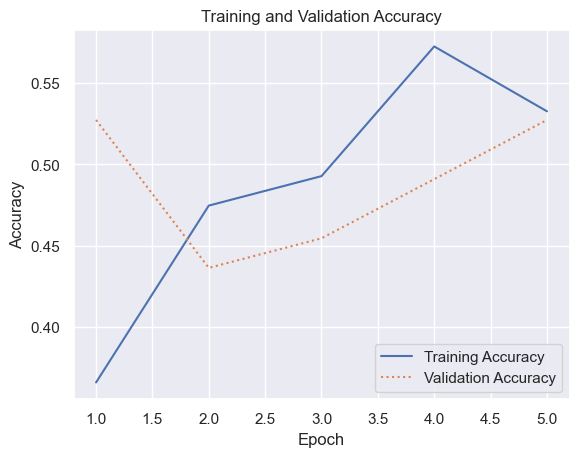

In [42]:
view_accuracy_metrics(hist)

In [43]:
bounds = model.predict(X_test)

2/2 [==============================] - 0s 267ms/step


In [44]:
bounds

array([[ 5.19004107e-01,  4.34619814e-01,  5.39936543e-01,
         4.99853432e-01],
       [ 2.06434727e-02,  1.95781179e-02,  3.70944627e-02,
         1.99802909e-02],
       [ 5.15512824e-01,  4.29069221e-01,  5.42246819e-01,
         4.79898721e-01],
       [ 4.36580867e-01,  3.87442589e-01,  4.59980398e-01,
         4.49449569e-01],
       [ 5.04401624e-01,  4.30180073e-01,  5.45263648e-01,
         5.15681028e-01],
       [ 4.88926440e-01,  4.01595026e-01,  5.14403880e-01,
         4.43400800e-01],
       [ 5.30628383e-01,  4.41453218e-01,  5.51402152e-01,
         5.04095316e-01],
       [ 5.02794623e-01,  4.34392571e-01,  5.45133829e-01,
         5.19093812e-01],
       [ 4.98633236e-01,  4.32318419e-01,  5.40702581e-01,
         5.15068233e-01],
       [ 5.54340519e-03, -2.44654007e-02, -1.48973465e-02,
         4.56565991e-04],
       [ 1.13745201e-02,  4.64440789e-03,  8.53750668e-03,
         3.33000347e-02],
       [ 5.30287087e-01,  4.39827621e-01,  5.55625319e-01,
      

In [23]:
view_image(X_test[0], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

#### Copying VGG16 model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [25]:
def show_feat_map(model, data):
    ''' 
    show_feat_map displays the feature map (image) after each filter is applied. 

    :param result: takes in the 4D tensor output from MaxPooling2D layer with format (batch_size, rows, cols, channels). 
    '''

    model.build()
    model.summary()
    result = model.predict(data)
    for i in range(64):
        feature_img = result[0, :, :, i]
        ax = plt.subplot(8, 8, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_img, cmap='grey')
    plt.show


In [26]:
model = Sequential()

In [27]:
#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(512, 512, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

In [28]:
#show_feat_map(model, X_test)

In [29]:
#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [30]:

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [31]:
#show_feat_map(model, X_test)

In [32]:
#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [33]:
#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [34]:
#show_feat_map(model, X_test)

In [35]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

In [36]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 512, 512, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 256, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                  

In [37]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=5)

Epoch 1/5


NotFoundError: Graph execution error:

Detected at node 'sequential_1/conv2d_7/Relu' defined at (most recent call last):
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\owend\AppData\Local\Temp\ipykernel_2556\3511421764.py", line 1, in <module>
      hist = model.fit(X_train, y_train,
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_7/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 352912400 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16781824 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3036676096 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3036676096 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18417152 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18417152 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 110362624 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 110362624 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2435055616 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2435055616 bytes.
	 [[{{node sequential_1/conv2d_7/Relu}}]] [Op:__inference_train_function_6903]

In [ ]:
view_accuracy_metrics(hist)

In [ ]:
bounds = model.predict(X_test)
view_image(X_test[0], int(bounds[1][0]*255),
            int(bounds[1][1]*255), int(bounds[1][2]*255), int(bounds[1][3]*255))